In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/infosec/cicids2017_cleaned.csv')

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('cicids2017_cleaned.csv')

# Just checking how many normal vs. attack samples we’ve got
print("--- Attack Type Breakdown ---")
print(df['Attack Type'].value_counts())

# cleaning-----

# Replace infinite values with NaN so we can drop them cleanly
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop any rows that still have missing data
df.dropna(inplace=True)

# prep data for training----------

# Separate features from the target label
X = df.drop('Attack Type', axis=1)
y = df['Attack Type']

# Convert 'Benign' to 0 and everything else to 1 (i.e., attack = 1)
y = y.apply(lambda x: 0 if x == 'Benign' else 1)

# Standardize the features so they’re on the same scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset 70% for training, 30% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("\n--- Done preprocessing! ---")
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


FileNotFoundError: [Errno 2] No such file or directory: 'cicids2017_cleaned.csv'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Clean up the data — drop any rows with NaNs or weird infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Split features and labels
X = df.drop('Attack Type', axis=1)  # 'Attack Type' is the target column
y = df['Attack Type']

# Convert labels: 'Benign' = 0, everything else = 1 (i.e., attacks)
# y = y.apply(lambda x: 0 if x == 'Benign' else 1)
y = y.apply(lambda x: 0 if x == 'Normal Traffic' else 1)

# Scale the features so they’re all on the same playing field
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets (70/30), stratify to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("--- Data Preprocessing Complete ---")
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("\nReady for model training.")


--- Data Preprocessing Complete ---
Train set shape: (1764525, 52)
Test set shape: (756226, 52)

Ready for model training.


In [ ]:
print("전체 레이블 분포:")
print(y.value_counts())

print("\n훈련/테스트 분포:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

# 원본 데이터 분포
print("\n원본 데이터 분포:")
print(df['Attack Type'].value_counts())

전체 레이블 분포:
Attack Type
0    2095057
1     425694
Name: count, dtype: int64

훈련/테스트 분포:
Attack Type
0    1466539
1     297986
Name: count, dtype: int64
Attack Type
0    628518
1    127708
Name: count, dtype: int64

원본 데이터 분포:
Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64


Modeling

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam

def evaluate_model(name, y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print(f"\n📊 {name}")
    print(f"  - Accuracy : {acc:.4f}")
    print(f"  - F1 Score : {f1:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(name)
    plt.show()


📊 Logistic Regression
  - Accuracy : 0.9547
  - F1 Score : 0.8636


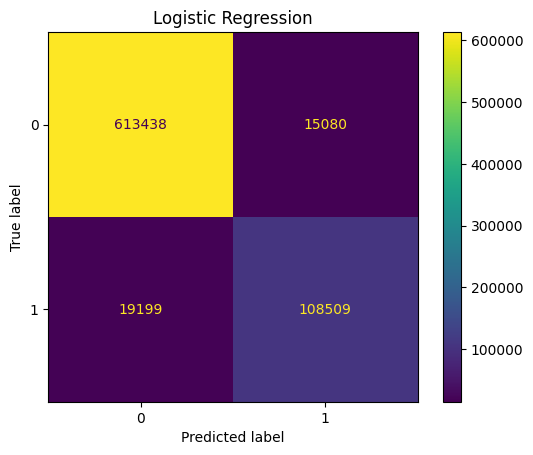

In [ ]:
# 1. Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
evaluate_model("Logistic Regression", y_test, lr_preds)


📊 Random Forest
  - Accuracy : 0.9985
  - F1 Score : 0.9956


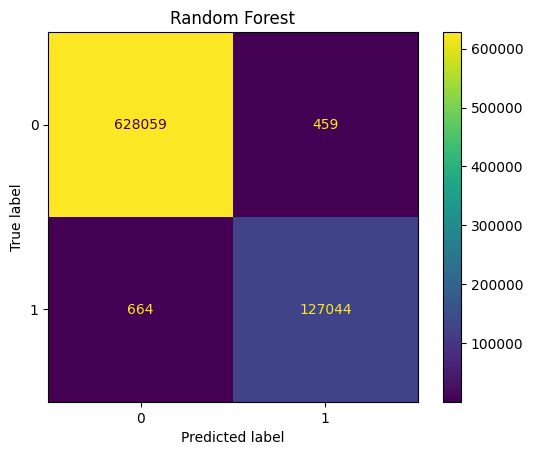

In [ ]:
# 2. Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
evaluate_model("Random Forest", y_test, rf_preds)


📊 LightGBM
  - Accuracy : 0.9989
  - F1 Score : 0.9967


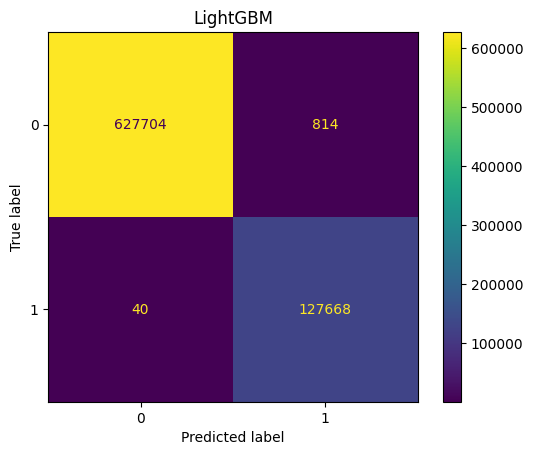

In [ ]:
# 3. LightGBM
import time

train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting_type': 'gbdt',
    'verbosity': -1
}
model_lgb = lgb.train(params, train_data, num_boost_round=100)
lgb_preds_prob = model_lgb.predict(X_test)
lgb_preds = [1 if p > 0.5 else 0 for p in lgb_preds_prob]
evaluate_model("LightGBM", y_test, lgb_preds)

Epoch 1/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.0047 - val_loss: 3.5874e-05
Epoch 2/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 2.9711e-05 - val_loss: 1.6150e-05
Epoch 3/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 1.4231e-05 - val_loss: 9.6805e-06
Epoch 4/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - loss: 9.1861e-06 - val_loss: 8.4164e-06
Epoch 5/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 8.1564e-06 - val_loss: 7.6489e-06
Epoch 6/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 7.2119e-06 - val_loss: 7.8629e-06
Epoch 7/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 6.1407e-06 - val_loss: 6.4387e-06
Epoch 8/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - loss: 5.8453e-06 - val_loss: 6.0782e-06
Epoch 9/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - loss: 5.8422e-06 - val_loss: 5.9161e-06
Epoch 10/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 5.6890e-06 - val_loss: 6.0221e-06
23633/23633 ━━━━━━━━━━━━━━━━━━━━ 

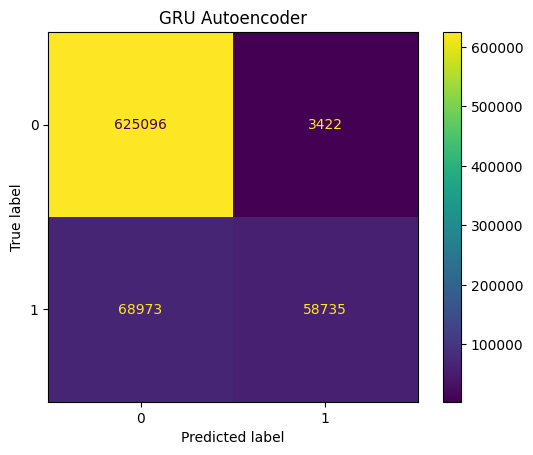

In [ ]:
# 4. GRU Autoencoder (비지도)
from sklearn.preprocessing import MinMaxScaler

# Autoencoder는 보통 MinMaxScaler 사용
scaler_ae = MinMaxScaler()
X_scaled_ae = scaler_ae.fit_transform(X_train)  # train 기준

# GRU AE는 3D 입력 필요 (samples, timesteps, features)
# 여기에선 timesteps=1 (각 sample = 하나의 시퀀스)
X_train_seq = X_scaled_ae.reshape(X_scaled_ae.shape[0], 1, X_scaled_ae.shape[1])
X_test_seq = scaler_ae.transform(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

# 정상 샘플만 학습에 사용
X_train_normal = X_train_seq[y_train == 0]

input_dim = X_train_seq.shape[2]
timesteps = 1

inputs = Input(shape=(timesteps, input_dim))
encoded = GRU(32, return_sequences=False)(inputs)
repeat = RepeatVector(timesteps)(encoded)
decoded = GRU(32, return_sequences=True)(repeat)
outputs = TimeDistributed(Dense(input_dim))(decoded)

gru_ae = Model(inputs, outputs)
gru_ae.compile(optimizer=Adam(), loss='mse')
gru_ae.fit(X_train_normal, X_train_normal, epochs=10, batch_size=256, validation_split=0.1, verbose=1)

# 예측 (복원)
reconstructions = gru_ae.predict(X_test_seq)
mse = np.mean(np.power(X_test_seq - reconstructions, 2), axis=(1,2))

# threshold = 평균 + 2*표준편차
threshold = np.mean(mse[y_test == 0]) + 2*np.std(mse[y_test == 0])
ae_preds = [1 if err > threshold else 0 for err in mse]

evaluate_model("GRU Autoencoder", y_test, ae_preds)

시드 고정된 버전으로 재시도


📊 Random Forest
  - Accuracy : 0.9985
  - F1 Score : 0.9956


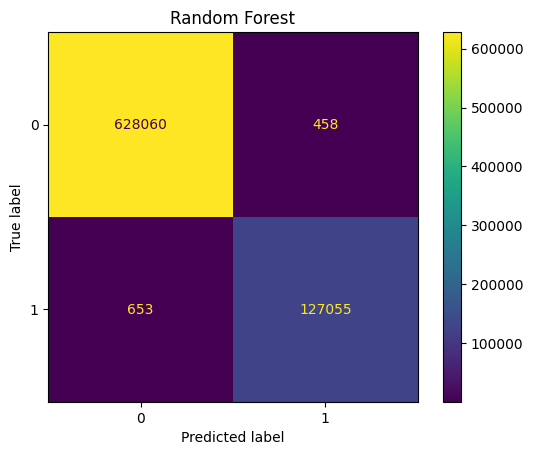


📊 LightGBM
  - Accuracy : 0.9988
  - F1 Score : 0.9965


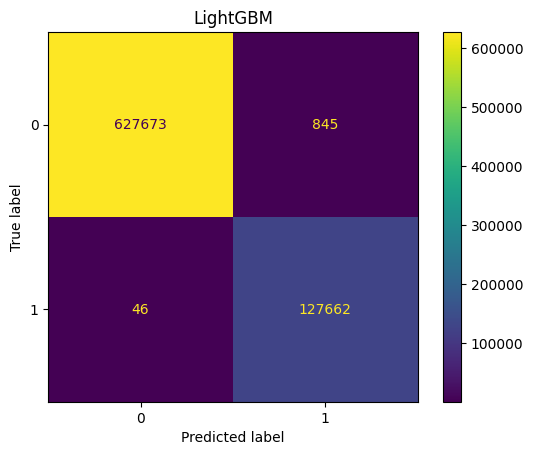

Epoch 1/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 0.0042 - val_loss: 3.5047e-05
Epoch 2/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 2.8662e-05 - val_loss: 1.4439e-05
Epoch 3/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 1.3487e-05 - val_loss: 8.9531e-06
Epoch 4/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 9.1846e-06 - val_loss: 8.0273e-06
Epoch 5/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 7.8188e-06 - val_loss: 6.6397e-06
Epoch 6/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 6.6468e-06 - val_loss: 5.8813e-06
Epoch 7/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 5.9175e-06 - val_loss: 5.0944e-06
Epoch 8/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 5.3069e-06 - val_loss: 4.8734e-06
Epoch 9/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 5.0734e-06 - val_loss: 4.7158e-06
Epoch 10/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 4.9739e-06 - val_loss: 4.7428e-06
23633/23633 ━━━━━━━━━━━━━━━━━━━━ 

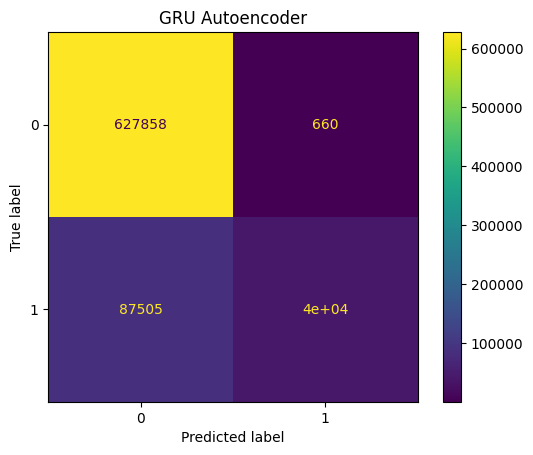

In [ ]:
# 랜덤 시드 고정 (재현 가능성 보장)
import numpy as np
import random
import tensorflow as tf

SEED = 42
np.random.seed(SEED)           # numpy 시드 고정
random.seed(SEED)              # python random 시드 고정
tf.random.set_seed(SEED)       # TensorFlow 시드 고정

# -----------------------------------
# 2. Random Forest
# -----------------------------------
from sklearn.ensemble import RandomForestClassifier

# ✅ random_state 추가
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
evaluate_model("Random Forest", y_test, rf_preds)

# -----------------------------------
# 3. LightGBM
# -----------------------------------
import lightgbm as lgb
import time

train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'seed': SEED  # ✅ LightGBM 시드 고정
}
model_lgb = lgb.train(params, train_data, num_boost_round=100)
lgb_preds_prob = model_lgb.predict(X_test)
lgb_preds = [1 if p > 0.5 else 0 for p in lgb_preds_prob]
evaluate_model("LightGBM", y_test, lgb_preds)

# -----------------------------------
# 4. GRU Autoencoder (Unsupervised)
# -----------------------------------
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

scaler_ae = MinMaxScaler()
X_scaled_ae = scaler_ae.fit_transform(X_train)

X_train_seq = X_scaled_ae.reshape(X_scaled_ae.shape[0], 1, X_scaled_ae.shape[1])
X_test_seq = scaler_ae.transform(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

X_train_normal = X_train_seq[y_train == 0]

input_dim = X_train_seq.shape[2]
timesteps = 1

inputs = Input(shape=(timesteps, input_dim))
encoded = GRU(32, return_sequences=False)(inputs)
repeat = RepeatVector(timesteps)(encoded)
decoded = GRU(32, return_sequences=True)(repeat)
outputs = TimeDistributed(Dense(input_dim))(decoded)

gru_ae = Model(inputs, outputs)
gru_ae.compile(optimizer=Adam(), loss='mse')

gru_ae.fit(
    X_train_normal,
    X_train_normal,
    epochs=10,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)

# 예측
reconstructions = gru_ae.predict(X_test_seq)
mse = np.mean(np.power(X_test_seq - reconstructions, 2), axis=(1, 2))

threshold = np.mean(mse[y_test == 0]) + 2 * np.std(mse[y_test == 0])
ae_preds = [1 if err > threshold else 0 for err in mse]

evaluate_model("GRU Autoencoder", y_test, ae_preds)


# precision, recall, roc-auc 추가한 최종 코드

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

def evaluate_model(name, y_true, y_pred, probas=None):
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"\n📊 {name}")
    print(f"  - Accuracy  : {acc:.4f}")
    print(f"  - Precision : {precision:.4f}")
    print(f"  - Recall    : {recall:.4f}")
    print(f"  - F1 Score  : {f1:.4f}")

    # ROC-AUC는 확률 예측이 있어야 계산 가능
    if probas is not None:
        auc = roc_auc_score(y_true, probas)
        print(f"  - ROC-AUC   : {auc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(name)
    plt.show()


⏱️ Logistic Regression Inference Time: 0.0730 seconds
   - Per sample: 0.000000 seconds

📊 Logistic Regression
  - Accuracy  : 0.9547
  - Precision : 0.8780
  - Recall    : 0.8497
  - F1 Score  : 0.8636


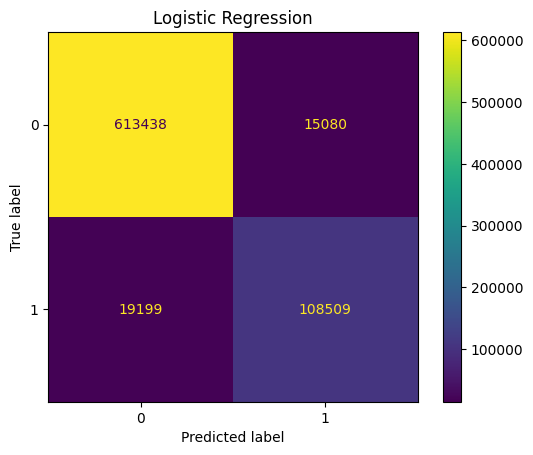


⏱️ Random Forest Inference Time: 7.0169 seconds
   - Per sample: 0.000009 seconds

📊 Random Forest
  - Accuracy  : 0.9985
  - Precision : 0.9964
  - Recall    : 0.9949
  - F1 Score  : 0.9956


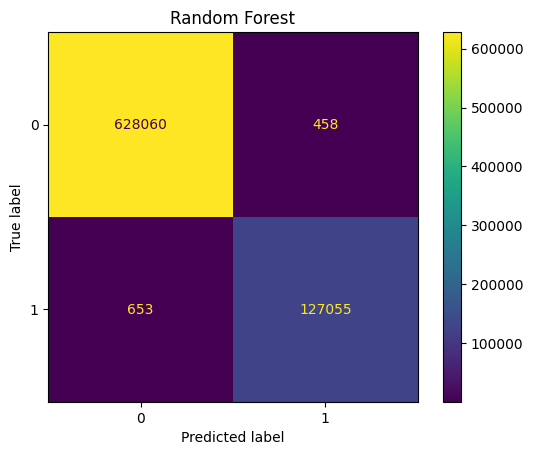


⏱️ LightGBM Inference Time: 3.0272 seconds
   - Per sample: 0.000004 seconds

📊 LightGBM
  - Accuracy  : 0.9988
  - Precision : 0.9934
  - Recall    : 0.9996
  - F1 Score  : 0.9965
  - ROC-AUC   : 0.9999


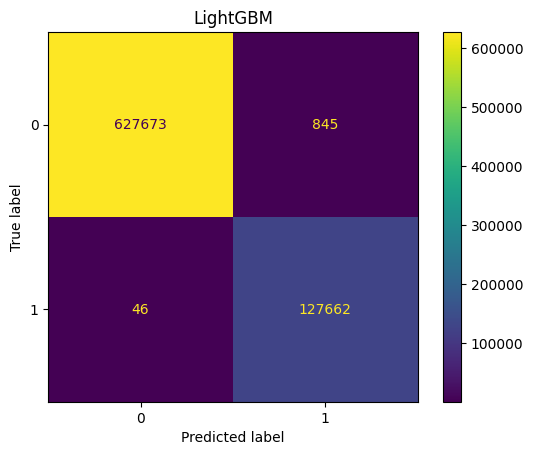

NameError: name 'gru_ae' is not defined

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import random
import tensorflow as tf

SEED = 42
np.random.seed(SEED)           # numpy 시드 고정
random.seed(SEED)              # python random 시드 고정
tf.random.set_seed(SEED)       # TensorFlow 시드 고정

# -----------------------------
# 1. Logistic Regression
# -----------------------------
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

start = time.time()
lr_preds = lr.predict(X_test)
end = time.time()
print(f"\n⏱️ Logistic Regression Inference Time: {(end - start):.4f} seconds")
print(f"   - Per sample: {(end - start)/len(X_test):.6f} seconds")

evaluate_model("Logistic Regression", y_test, lr_preds)

# -----------------------------
# 2. Random Forest
# -----------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf.fit(X_train, y_train)

start = time.time()
rf_preds = rf.predict(X_test)
end = time.time()
print(f"\n⏱️ Random Forest Inference Time: {(end - start):.4f} seconds")
print(f"   - Per sample: {(end - start)/len(X_test):.6f} seconds")

evaluate_model("Random Forest", y_test, rf_preds)

# -----------------------------
# 3. LightGBM
# -----------------------------
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'seed': SEED
}
model_lgb = lgb.train(params, train_data, num_boost_round=100)

start = time.time()
lgb_preds_prob = model_lgb.predict(X_test)
end = time.time()
print(f"\n⏱️ LightGBM Inference Time: {(end - start):.4f} seconds")
print(f"   - Per sample: {(end - start)/len(X_test):.6f} seconds")

lgb_preds = [1 if p > 0.5 else 0 for p in lgb_preds_prob]
evaluate_model("LightGBM", y_test, lgb_preds, probas=lgb_preds_prob)


Epoch 1/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.0042 - val_loss: 3.5047e-05
Epoch 2/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 2.8662e-05 - val_loss: 1.4439e-05
Epoch 3/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 1.3487e-05 - val_loss: 8.9531e-06
Epoch 4/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 9.1846e-06 - val_loss: 8.0273e-06
Epoch 5/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - loss: 7.8188e-06 - val_loss: 6.6397e-06
Epoch 6/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 6.6468e-06 - val_loss: 5.8813e-06
Epoch 7/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 5.9175e-06 - val_loss: 5.0944e-06
Epoch 8/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 5.3069e-06 - val_loss: 4.8734e-06
Epoch 9/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 5.0734e-06 - val_loss: 4.7158e-06
Epoch 10/10
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step - loss: 4.9739e-06 - val_loss: 4.7428e-06
23633/23633 ━━━━━━━━━━━━━━━━━━━━ 

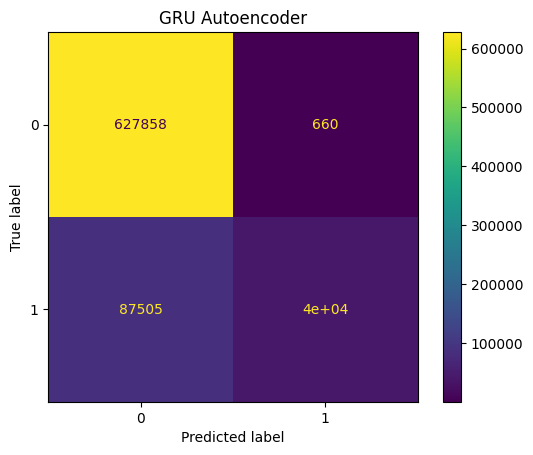

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# -----------------------------
# 4. GRU Autoencoder
# -----------------------------

# Scaling & 데이터 변형
scaler_ae = MinMaxScaler()
X_scaled_ae = scaler_ae.fit_transform(X_train)
X_train_seq = X_scaled_ae.reshape(X_scaled_ae.shape[0], 1, X_scaled_ae.shape[1])
X_test_seq = scaler_ae.transform(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])
X_train_normal = X_train_seq[y_train == 0]

# 모델 정의 및 학습
input_dim = X_train_seq.shape[2]
timesteps = 1
inputs = Input(shape=(timesteps, input_dim))
encoded = GRU(32, return_sequences=False)(inputs)
repeat = RepeatVector(timesteps)(encoded)
decoded = GRU(32, return_sequences=True)(repeat)
outputs = TimeDistributed(Dense(input_dim))(decoded)

gru_ae = Model(inputs, outputs)
gru_ae.compile(optimizer=Adam(), loss='mse')
gru_ae.fit(
    X_train_normal,
    X_train_normal,
    epochs=10,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)

reconstructions = gru_ae.predict(X_test_seq)

start = time.time()
reconstructions = gru_ae.predict(X_test_seq)
end = time.time()
print(f"\n⏱️ GRU Autoencoder Inference Time: {(end - start):.4f} seconds")
print(f"   - Per sample: {(end - start)/len(X_test):.6f} seconds")

mse = np.mean(np.power(X_test_seq - reconstructions, 2), axis=(1, 2))
threshold = np.mean(mse[y_test == 0]) + 2 * np.std(mse[y_test == 0])
ae_preds = [1 if err > threshold else 0 for err in mse]
evaluate_model("GRU Autoencoder", y_test, ae_preds, probas=mse)